In [1]:
#http://dacatay.com/data-science/part-6-time-series-prediction-neural-networks-python/

In [16]:
%run 'data_preparation.ipynb'

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#  Supervised Learning

In [118]:
# set seed
np.random.seed(7)

# prepare the data set
per_day = year.pivot_table(index=['BOOKING_DATE'],values=['BOOKING_HAL_ID'], aggfunc=lambda x: len(x.unique()))
#per_day.reset_index(inplace=True)

data = per_day.values

# using keras often requires the data type float32
data = data.astype('float32')

In [119]:
# slice the data
train = data[:950]
test = data[950:]

In [120]:
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        b = data[row + lags, 0]
        y.append(b)
    return np.array(X), np.array(y)

In [121]:
lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test     # due to naming convention

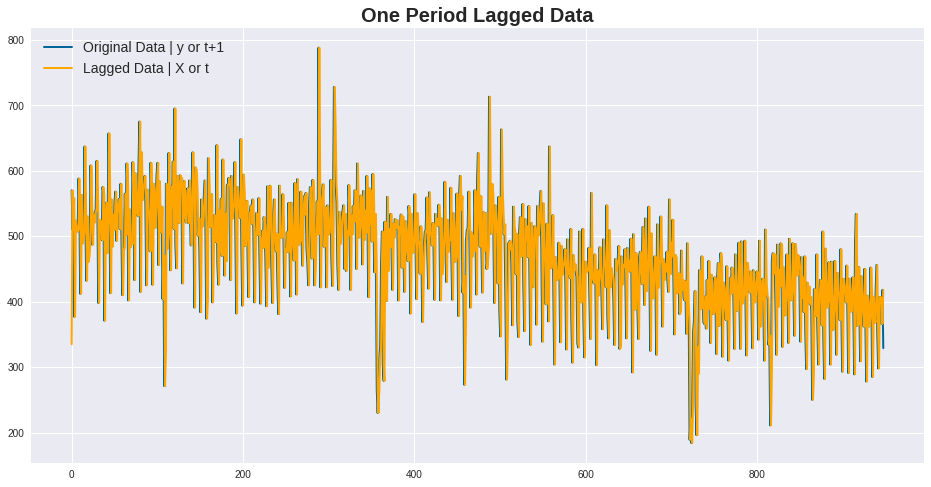

In [122]:
# plot the created data
plt.plot(y_train, label='Original Data | y or t+1', color='#006699')
plt.plot(X_train, label='Lagged Data | X or t', color='orange')
plt.legend(loc='upper left')
plt.title('One Period Lagged Data')
#plt.savefig('./img/ann_training.png')
plt.show()

# Multilayer Perceptron Network

In [123]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(3, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
 - 1s - loss: 60253.2598
Epoch 2/200
 - 1s - loss: 7779.4902
Epoch 3/200
 - 1s - loss: 7626.8205
Epoch 4/200
 - 1s - loss: 7636.9461
Epoch 5/200
 - 1s - loss: 7627.6204
Epoch 6/200
 - 1s - loss: 7637.9327
Epoch 7/200
 - 1s - loss: 7651.8190
Epoch 8/200
 - 1s - loss: 7626.4801
Epoch 9/200
 - 1s - loss: 7625.7652
Epoch 10/200
 - 1s - loss: 7639.3501
Epoch 11/200
 - 1s - loss: 7641.2178
Epoch 12/200
 - 1s - loss: 7648.0581
Epoch 13/200
 - 1s - loss: 7619.9166
Epoch 14/200
 - 1s - loss: 7587.7409
Epoch 15/200
 - 1s - loss: 7615.2296
Epoch 16/200
 - 1s - loss: 7613.8456
Epoch 17/200
 - 1s - loss: 7627.5637
Epoch 18/200
 - 1s - loss: 7579.9045
Epoch 19/200
 - 1s - loss: 7627.7391
Epoch 20/200
 - 1s - loss: 7607.6370
Epoch 21/200
 - 1s - loss: 7585.9502
Epoch 22/200
 - 1s - loss: 7612.7673
Epoch 23/200
 - 1s - loss: 7595.4836
Epoch 24/200
 - 1s - loss: 7576.6150
Epoch 25/200
 - 1s - loss: 7600.2457
Epoch 26/200
 - 1s - loss: 7608.8450
Epoch 27/200
 - 1s - loss: 7609.8841
Epoch 28/

In [124]:
# estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 7205.61 MSE (84.89 RMSE)
Test Score: 3641.28 MSE (60.34 RMSE)


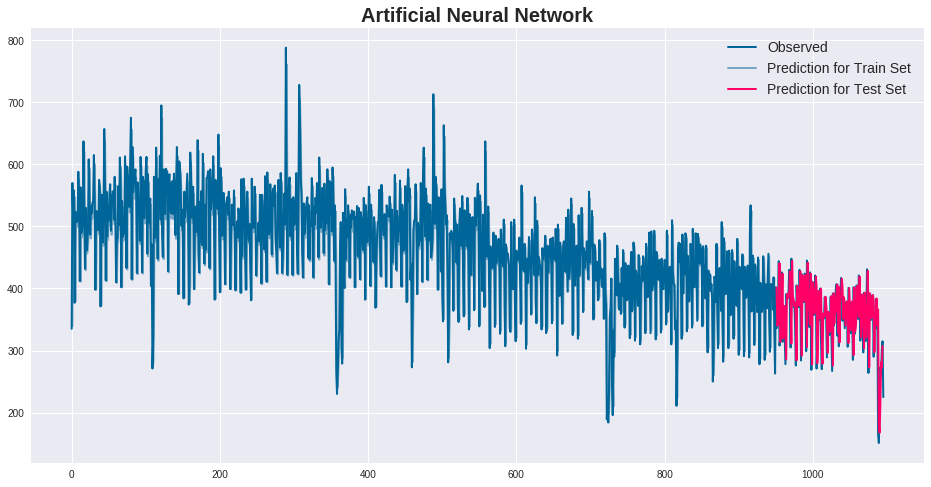

In [125]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(data)-1, :] = test_predict

# plot baseline and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='best');
plt.title('Artificial Neural Network')
#plt.savefig('./img/ann_forecast.png')
plt.show()

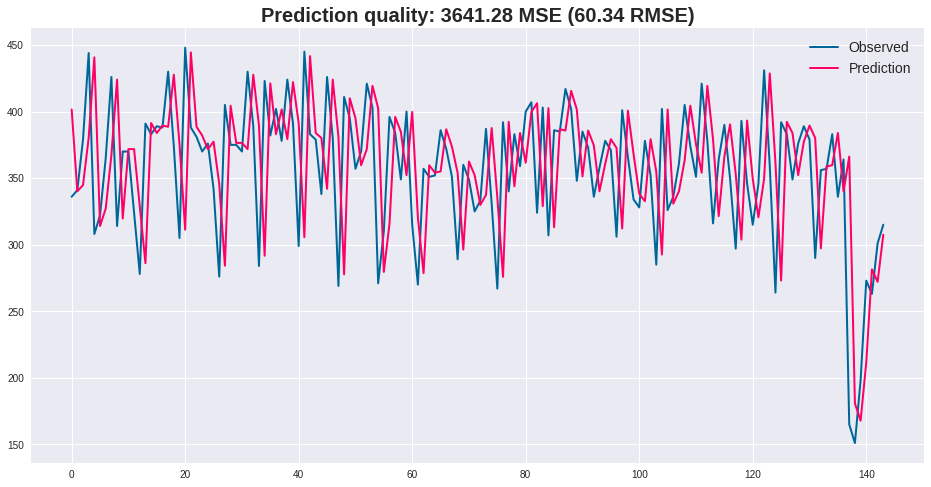

In [126]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='best');
#plt.savefig('./img/ann_close.png')
plt.show()

# Multilayer perceptron with window

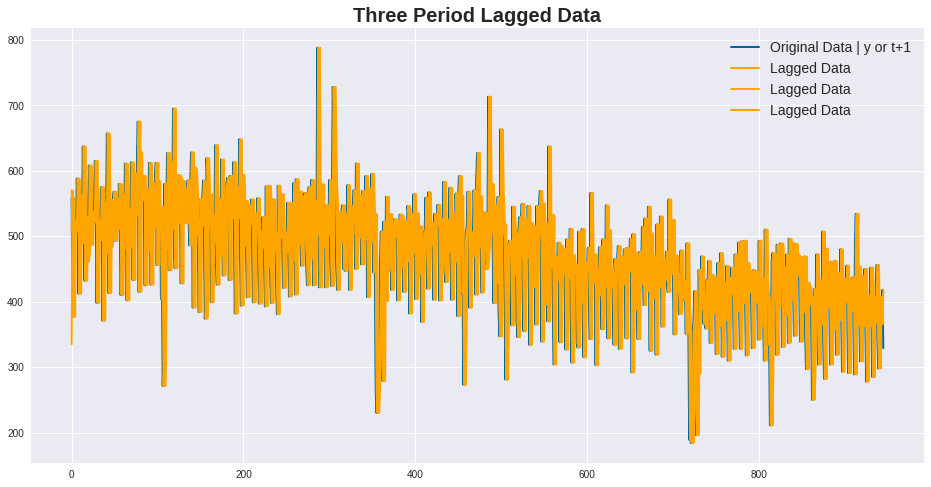

In [127]:
# reshape and lag shift the dataset
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

# plot the created data
plt.plot(y_train, label='Original Data | y or t+1', color='#006699')
plt.plot(X_train, label='Lagged Data', color='orange')
plt.legend(loc='best')
plt.title('Three Period Lagged Data')
#plt.savefig('./img/ann3_training.png')
plt.show()


In [128]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(4, input_dim=lags, activation='relu'))
mdl.add(Dense(8, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=400, batch_size=2, verbose=2)

Epoch 1/400
 - 2s - loss: 25542.6921
Epoch 2/400
 - 1s - loss: 5333.5219
Epoch 3/400
 - 1s - loss: 5035.7061
Epoch 4/400
 - 1s - loss: 4936.3346
Epoch 5/400
 - 1s - loss: 4899.8732
Epoch 6/400
 - 1s - loss: 4840.2671
Epoch 7/400
 - 1s - loss: 4879.1768
Epoch 8/400
 - 1s - loss: 4810.1595
Epoch 9/400
 - 1s - loss: 4786.2870
Epoch 10/400
 - 1s - loss: 4771.6138
Epoch 11/400
 - 1s - loss: 4788.5061
Epoch 12/400
 - 1s - loss: 4771.4880
Epoch 13/400
 - 1s - loss: 4820.6107
Epoch 14/400
 - 1s - loss: 4737.3880
Epoch 15/400
 - 1s - loss: 4763.6848
Epoch 16/400
 - 1s - loss: 4715.0503
Epoch 17/400
 - 1s - loss: 4788.2872
Epoch 18/400
 - 1s - loss: 4719.0559
Epoch 19/400
 - 1s - loss: 4732.4814
Epoch 20/400
 - 1s - loss: 4670.5673
Epoch 21/400
 - 1s - loss: 4621.0409
Epoch 22/400
 - 1s - loss: 4623.5666
Epoch 23/400
 - 1s - loss: 4681.9936
Epoch 24/400
 - 1s - loss: 4584.0409
Epoch 25/400
 - 1s - loss: 4635.4084
Epoch 26/400
 - 1s - loss: 4541.3013
Epoch 27/400
 - 1s - loss: 4614.1912
Epoch 28/

Epoch 220/400
 - 1s - loss: 4299.5064
Epoch 221/400
 - 1s - loss: 4278.6694
Epoch 222/400
 - 1s - loss: 4315.9282
Epoch 223/400
 - 1s - loss: 4216.0785
Epoch 224/400
 - 1s - loss: 4370.2555
Epoch 225/400
 - 1s - loss: 4240.1108
Epoch 226/400
 - 1s - loss: 4334.0381
Epoch 227/400
 - 1s - loss: 4336.3678
Epoch 228/400
 - 1s - loss: 4307.9360
Epoch 229/400
 - 1s - loss: 4314.2864
Epoch 230/400
 - 1s - loss: 4310.9755
Epoch 231/400
 - 1s - loss: 4274.3118
Epoch 232/400
 - 1s - loss: 4350.0764
Epoch 233/400
 - 1s - loss: 4356.3963
Epoch 234/400
 - 1s - loss: 4280.4752
Epoch 235/400
 - 1s - loss: 4306.1216
Epoch 236/400
 - 1s - loss: 4277.9272
Epoch 237/400
 - 1s - loss: 4323.0554
Epoch 238/400
 - 1s - loss: 4334.4390
Epoch 239/400
 - 1s - loss: 4319.5560
Epoch 240/400
 - 1s - loss: 4343.8707
Epoch 241/400
 - 1s - loss: 4299.7561
Epoch 242/400
 - 1s - loss: 4326.8016
Epoch 243/400
 - 1s - loss: 4270.8123
Epoch 244/400
 - 1s - loss: 4380.5423
Epoch 245/400
 - 1s - loss: 4247.6551
Epoch 246/40

In [129]:
# Estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 4199.86 MSE (64.81 RMSE)
Test Score: 2131.31 MSE (46.17 RMSE)


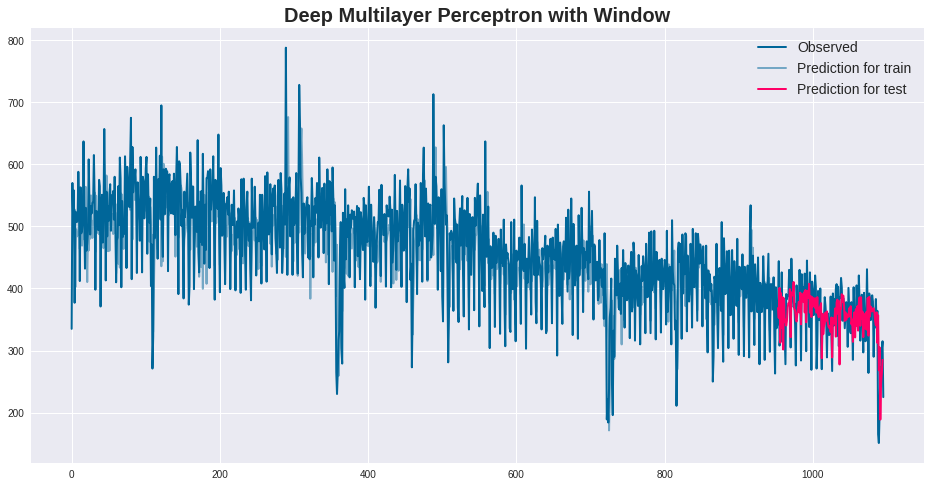

In [130]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags * 2)+1:len(data)-1, :] = test_predict

# plot observation and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for train', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for test', color='#ff0066');
plt.legend(loc='best')
plt.title('Deep Multilayer Perceptron with Window')
#plt.savefig('./img/ann3_forecast.png')
plt.show()

In [131]:
y_test

array([379., 444., 308., 322., 365., 426., 314., 370., 370., 324., 278.,
       391., 383., 389., 388., 430., 374., 305., 448., 388., 381., 370.,
       376., 342., 276., 405., 375., 375., 370., 430., 389., 284., 423.,
       382., 402., 378., 424., 391., 299., 445., 383., 379., 338., 426.,
       380., 269., 411., 395., 357., 370., 421., 403., 271., 310., 396.,
       384., 349., 400., 315., 270., 357., 351., 352., 386., 372., 351.,
       289., 360., 349., 325., 333., 387., 331., 267., 392., 340., 383.,
       359., 400., 407., 324., 403., 307., 386., 385., 417., 402., 348.,
       385., 373., 336., 358., 378., 371., 306., 401., 366., 334., 328.,
       378., 352., 285., 402., 326., 336., 361., 405., 374., 351., 421.,
       378., 316., 364., 390., 350., 297., 393., 346., 315., 346., 431.,
       359., 264., 392., 383., 349., 376., 389., 379., 290., 356., 357.,
       383., 336., 364., 165., 151., 198., 273., 263., 301., 315.],
      dtype=float32)

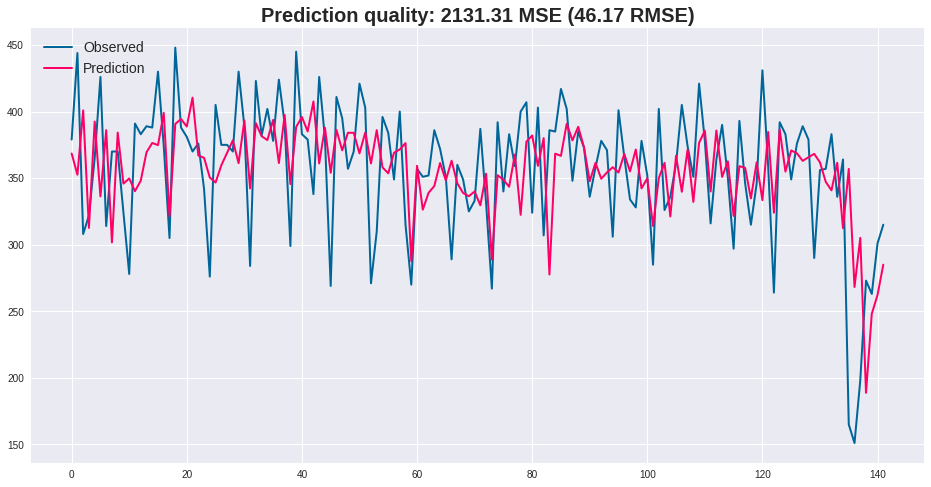

In [132]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left');
#plt.savefig('./img/ann3_close.png')
plt.show()

# LSTM Recurrent Neural Network

In [133]:
# fix random seed for reproducibility
np.random.seed(1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# split into train and test sets
train = dataset[0:950, :]
test = dataset[950:, :]

# reshape into X=t and Y=t+1
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [134]:
# create and fit the LSTM network
mdl = Sequential()
mdl.add(Dense(3, input_shape=(1, lags), activation='relu'))
mdl.add(LSTM(6, activation='relu'))
mdl.add(Dense(1, activation='relu'))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.0260
Epoch 2/100
 - 3s - loss: 0.0128
Epoch 3/100
 - 3s - loss: 0.0124
Epoch 4/100
 - 4s - loss: 0.0126
Epoch 5/100
 - 3s - loss: 0.0122
Epoch 6/100
 - 3s - loss: 0.0123
Epoch 7/100
 - 2s - loss: 0.0122
Epoch 8/100
 - 3s - loss: 0.0120
Epoch 9/100
 - 2s - loss: 0.0121
Epoch 10/100
 - 2s - loss: 0.0121
Epoch 11/100
 - 2s - loss: 0.0121
Epoch 12/100
 - 2s - loss: 0.0120
Epoch 13/100
 - 2s - loss: 0.0121
Epoch 14/100
 - 3s - loss: 0.0120
Epoch 15/100
 - 2s - loss: 0.0122
Epoch 16/100
 - 2s - loss: 0.0121
Epoch 17/100
 - 2s - loss: 0.0121
Epoch 18/100
 - 2s - loss: 0.0120
Epoch 19/100
 - 2s - loss: 0.0120
Epoch 20/100
 - 2s - loss: 0.0120
Epoch 21/100
 - 2s - loss: 0.0120
Epoch 22/100
 - 2s - loss: 0.0119
Epoch 23/100
 - 2s - loss: 0.0121
Epoch 24/100
 - 2s - loss: 0.0119
Epoch 25/100
 - 2s - loss: 0.0119
Epoch 26/100
 - 2s - loss: 0.0119
Epoch 27/100
 - 2s - loss: 0.0119
Epoch 28/100
 - 2s - loss: 0.0120
Epoch 29/100
 - 2s - loss: 0.0120
Epoch 30/100
 - 2s - lo

In [135]:
# make predictions
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# invert transformation
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [136]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: {:.2f} RMSE'.format(train_score))
test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: {:.2f} RMSE'.format(test_score))

Train Score: 67.87 RMSE
Test Score: 55.58 RMSE


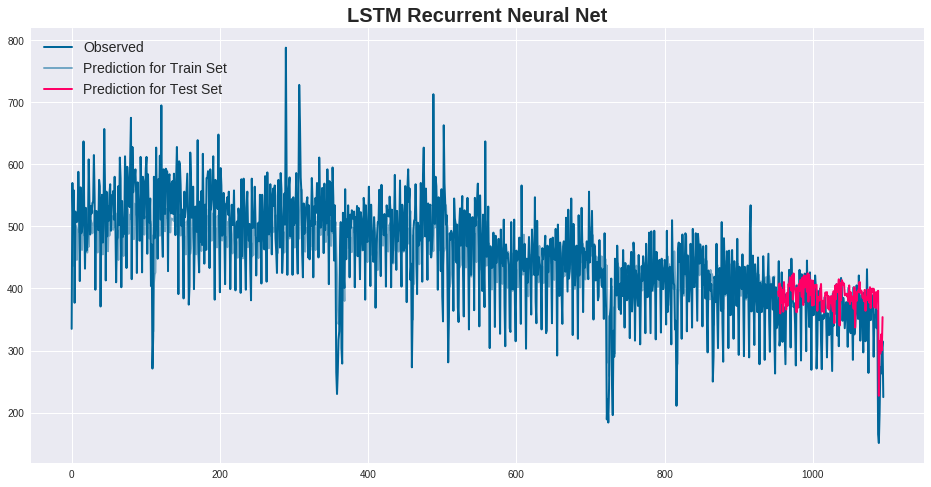

In [137]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags:len(train_predict)+lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (lags * 2)+1:len(data)-1, :] = test_predict

# plot observation and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='upper left')
plt.title('LSTM Recurrent Neural Net')
#plt.savefig('./img/lstm_forecast.png')
plt.show()

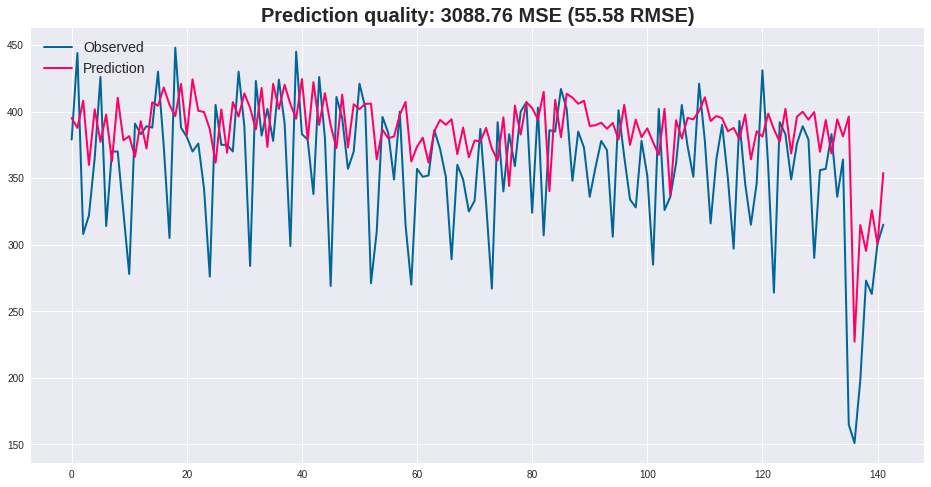

In [138]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left');
#plt.savefig('./img/lstm_close.png')
plt.show()

# Observations

# RMSE values for each model

#  Train/Test(60/40)

Multilayer perceptron

Multilayer perceptron with window

LSTM Recurrent Neural Network

# Train/Test(80/20)

Multilayer perceptron

Multilayer perceptron with window

LSTM Recurrent Neural Network

# Train/Test(90/10)

Multilayer perceptron

Multilayer perceptron with window

LSTM Recurrent Neural Network, epochs=100

LSTM Recurrent Neural Network, epochs=200